# How convolutional neural networks see the world

## An exploration of convnet filters with Keras
In this post, we take a look at what deep convolutional neural networks (convnets) really learn, and how they understand the images we feed them. We will use Keras to visualize inputs that maximize the activation of the filters in different layers of the VGG16 architecture, trained on ImageNet. All of the code used in this post can be found on [Github](https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py).
VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to [win the ILSVR (ImageNet) competition in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). To this day is it still considered to be an excellent vision model, although it has been somewhat outperformed by more revent advances such as Inception and ResNet.

In [17]:
# Define the VGG16 model in keras

from keras import applications
from keras import backend as K
from PIL import Image
import numpy as np
import matplotlib

# Build the VGG network without fully connected network.
# The model loads the pre-trained weights when weights is 'imagenet'
model = applications.VGG16(include_top=False, weights='imagenet')
print("Model loaded.")

Model loaded.


In [18]:
# Summary the model
# The reason why we use VGG without fully connected network is that
# the input image size doesn't have to match with (224, 224).

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [23]:
# Define the global variale

input_img = model.input # placeholder for the input images
layer_dict = dict([(layer.name, layer.output) for layer in model.layers[1:]])
img_width = 128 # image width
img_height = 128 # image height
layer_name = 'block5_conv1' # filter of layer considered

In [20]:
# The util function to convert a tensor to into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [21]:
# utility function to normalize a tensor by its L2 norm

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [28]:
# Generate images which maximize the activation of 200 filters of 
# some layer considered and choose best 64 to save

kept_filters = [] # store images which maxmize some filters

for filter_index in range(200):
    # In block5_conv1, the filter index can range from 0 to 511
    print('Processing filter %d'%filter_index)
    
    # We build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name]
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    
    # We compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]
    
    # Normalization trick: we normalize the gradient to avoid too
    # large or to small gradients
    grads = normalize(grads)
    iterate = K.function([input_img], [loss, grads])
    
    # Step size for gradient ascent
    step = 1.
    
    # We start from a gray image with some random noise
    # The input format is as follows:
    # (batch, channels, width, height) or (batch, width, height, channels)
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # We run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data +=  grads_value * step
        print("Current loss value:", loss_value)
        if loss_value <= 0:
            # Some filters get stuck to 0, we can skip them
            break
            
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8
kept_filters.sort(key=lambda x:x[1], reverse=True)
kept_filters = kept_filters[: n*n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

# save the result to disk
matplotlib.image.imsave('images/stitched_filters_%dx%d.png' % (n, n),stitched_filters)

Processing filter 0
Current loss value: 11.788
Current loss value: 25.2033
Current loss value: 42.5181
Current loss value: 65.6604
Current loss value: 91.1044
Current loss value: 114.227
Current loss value: 131.656
Current loss value: 153.212
Current loss value: 178.365
Current loss value: 205.926
Current loss value: 230.039
Current loss value: 258.183
Current loss value: 282.824
Current loss value: 309.089
Current loss value: 336.436
Current loss value: 365.395
Current loss value: 390.926
Current loss value: 416.467
Current loss value: 445.773
Current loss value: 472.307
Processing filter 1
Current loss value: 0.170773
Current loss value: 14.1246
Current loss value: 42.266
Current loss value: 63.3911
Current loss value: 94.5307
Current loss value: 145.708
Current loss value: 192.593
Current loss value: 247.851
Current loss value: 312.18
Current loss value: 368.758
Current loss value: 428.042
Current loss value: 482.671
Current loss value: 539.082
Current loss value: 599.054
Current lo

Current loss value: 0.0326819
Current loss value: 12.0738
Current loss value: 32.7924
Current loss value: 66.2105
Current loss value: 99.7267
Current loss value: 135.884
Current loss value: 165.855
Current loss value: 198.442
Current loss value: 239.268
Current loss value: 289.101
Current loss value: 329.644
Current loss value: 366.017
Current loss value: 402.458
Current loss value: 446.485
Current loss value: 488.81
Current loss value: 537.519
Current loss value: 583.133
Current loss value: 630.751
Current loss value: 669.405
Current loss value: 715.746
Processing filter 17
Current loss value: 0.663467
Current loss value: 13.1994
Current loss value: 36.0738
Current loss value: 64.428
Current loss value: 104.557
Current loss value: 151.693
Current loss value: 205.794
Current loss value: 267.359
Current loss value: 335.06
Current loss value: 397.868
Current loss value: 463.603
Current loss value: 540.505
Current loss value: 607.824
Current loss value: 688.344
Current loss value: 767.045

Current loss value: 0.0
Processing filter 36
Current loss value: 11.9195
Current loss value: 45.4665
Current loss value: 106.338
Current loss value: 164.036
Current loss value: 270.934
Current loss value: 367.233
Current loss value: 443.574
Current loss value: 514.206
Current loss value: 582.919
Current loss value: 649.739
Current loss value: 710.819
Current loss value: 769.439
Current loss value: 829.823
Current loss value: 892.768
Current loss value: 948.084
Current loss value: 1004.57
Current loss value: 1058.93
Current loss value: 1115.03
Current loss value: 1166.41
Current loss value: 1222.55
Processing filter 37
Current loss value: 0.956932
Current loss value: 49.2909
Current loss value: 193.134
Current loss value: 291.363
Current loss value: 385.837
Current loss value: 466.832
Current loss value: 547.595
Current loss value: 621.213
Current loss value: 697.489
Current loss value: 769.433
Current loss value: 838.307
Current loss value: 902.283
Current loss value: 969.911
Current l

Current loss value: 0.0
Processing filter 53
Current loss value: 70.7914
Current loss value: 179.236
Current loss value: 306.96
Current loss value: 409.324
Current loss value: 492.688
Current loss value: 563.941
Current loss value: 629.435
Current loss value: 699.098
Current loss value: 763.56
Current loss value: 827.478
Current loss value: 884.754
Current loss value: 942.393
Current loss value: 991.53
Current loss value: 1042.66
Current loss value: 1094.08
Current loss value: 1146.35
Current loss value: 1196.5
Current loss value: 1246.71
Current loss value: 1294.93
Current loss value: 1349.5
Processing filter 54
Current loss value: 0.0
Processing filter 55
Current loss value: 0.00618409
Current loss value: 9.37979
Current loss value: 35.2993
Current loss value: 80.0139
Current loss value: 136.492
Current loss value: 193.827
Current loss value: 242.893
Current loss value: 293.5
Current loss value: 340.905
Current loss value: 388.574
Current loss value: 432.029
Current loss value: 469.4

Current loss value: 2.44103
Current loss value: 21.6697
Current loss value: 55.6822
Current loss value: 93.9959
Current loss value: 129.51
Current loss value: 160.981
Current loss value: 198.474
Current loss value: 244.423
Current loss value: 284.256
Current loss value: 319.371
Current loss value: 353.701
Current loss value: 383.081
Current loss value: 415.418
Current loss value: 443.639
Current loss value: 475.524
Current loss value: 505.11
Current loss value: 534.501
Current loss value: 565.2
Current loss value: 592.415
Current loss value: 619.469
Processing filter 76
Current loss value: 9.99998
Current loss value: 38.3663
Current loss value: 103.076
Current loss value: 195.45
Current loss value: 276.002
Current loss value: 347.727
Current loss value: 402.324
Current loss value: 465.437
Current loss value: 532.335
Current loss value: 598.096
Current loss value: 669.901
Current loss value: 738.549
Current loss value: 805.742
Current loss value: 859.827
Current loss value: 933.435
Curr

Current loss value: 0.0
Processing filter 97
Current loss value: 4.12968
Current loss value: 41.2153
Current loss value: 105.094
Current loss value: 162.507
Current loss value: 210.711
Current loss value: 257.136
Current loss value: 307.779
Current loss value: 357.246
Current loss value: 399.903
Current loss value: 435.357
Current loss value: 476.332
Current loss value: 519.109
Current loss value: 555.032
Current loss value: 597.132
Current loss value: 637.687
Current loss value: 673.05
Current loss value: 711.787
Current loss value: 748.754
Current loss value: 784.676
Current loss value: 823.788
Processing filter 98
Current loss value: 0.291143
Current loss value: 2.32203
Current loss value: 25.9148
Current loss value: 52.7256
Current loss value: 86.7812
Current loss value: 125.591
Current loss value: 161.156
Current loss value: 204.071
Current loss value: 248.753
Current loss value: 293.808
Current loss value: 340.353
Current loss value: 380.688
Current loss value: 418.62
Current los

Current loss value: 0.0
Processing filter 121
Current loss value: 2.92313
Current loss value: 11.8987
Current loss value: 38.0434
Current loss value: 61.1699
Current loss value: 90.4103
Current loss value: 130.751
Current loss value: 160.185
Current loss value: 188.355
Current loss value: 221.252
Current loss value: 257.778
Current loss value: 290.501
Current loss value: 328.166
Current loss value: 362.652
Current loss value: 399.479
Current loss value: 437.489
Current loss value: 466.403
Current loss value: 500.465
Current loss value: 529.564
Current loss value: 565.058
Current loss value: 597.484
Processing filter 122
Current loss value: 0.641498
Current loss value: 3.04793
Current loss value: 20.2897
Current loss value: 51.7372
Current loss value: 72.9839
Current loss value: 96.0436
Current loss value: 123.77
Current loss value: 148.262
Current loss value: 181.053
Current loss value: 208.428
Current loss value: 237.655
Current loss value: 266.751
Current loss value: 300.254
Current 

Current loss value: 44.7405
Current loss value: 225.515
Current loss value: 381.299
Current loss value: 507.735
Current loss value: 613.178
Current loss value: 708.211
Current loss value: 813.502
Current loss value: 911.801
Current loss value: 1018.91
Current loss value: 1110.78
Current loss value: 1212.21
Current loss value: 1292.45
Current loss value: 1386.0
Current loss value: 1477.58
Current loss value: 1573.53
Current loss value: 1659.06
Current loss value: 1753.18
Current loss value: 1844.74
Current loss value: 1936.07
Current loss value: 2029.56
Processing filter 139
Current loss value: 12.2107
Current loss value: 34.1274
Current loss value: 74.4917
Current loss value: 126.099
Current loss value: 181.637
Current loss value: 233.995
Current loss value: 288.781
Current loss value: 345.944
Current loss value: 395.237
Current loss value: 438.669
Current loss value: 492.453
Current loss value: 537.697
Current loss value: 584.792
Current loss value: 630.383
Current loss value: 674.943

Current loss value: 16.1361
Current loss value: 36.7934
Current loss value: 44.6783
Current loss value: 76.9662
Current loss value: 103.201
Current loss value: 117.608
Current loss value: 144.159
Current loss value: 172.867
Current loss value: 216.908
Current loss value: 249.477
Current loss value: 287.459
Current loss value: 317.46
Current loss value: 357.606
Current loss value: 392.308
Current loss value: 436.378
Current loss value: 479.78
Current loss value: 519.469
Current loss value: 568.314
Current loss value: 614.165
Current loss value: 650.227
Processing filter 156
Current loss value: 0.0
Processing filter 157
Current loss value: 7.7627
Current loss value: 32.554
Current loss value: 87.3443
Current loss value: 182.953
Current loss value: 280.969
Current loss value: 367.831
Current loss value: 454.513
Current loss value: 532.93
Current loss value: 605.62
Current loss value: 675.599
Current loss value: 746.845
Current loss value: 819.939
Current loss value: 891.905
Current loss v

Current loss value: 3.06555
Current loss value: 9.98264
Current loss value: 20.0435
Current loss value: 56.4408
Current loss value: 108.446
Current loss value: 162.485
Current loss value: 208.189
Current loss value: 276.794
Current loss value: 348.324
Current loss value: 418.378
Current loss value: 475.795
Current loss value: 537.356
Current loss value: 594.261
Current loss value: 641.189
Current loss value: 696.124
Current loss value: 745.522
Current loss value: 788.927
Current loss value: 840.961
Current loss value: 888.101
Current loss value: 935.467
Processing filter 175
Current loss value: 2.35042
Current loss value: 27.5074
Current loss value: 79.076
Current loss value: 139.95
Current loss value: 201.693
Current loss value: 260.099
Current loss value: 314.134
Current loss value: 372.015
Current loss value: 427.614
Current loss value: 476.565
Current loss value: 529.002
Current loss value: 578.695
Current loss value: 629.443
Current loss value: 674.793
Current loss value: 720.538


Current loss value: 8.80085
Current loss value: 16.458
Current loss value: 36.9669
Current loss value: 70.1716
Current loss value: 114.965
Current loss value: 152.997
Current loss value: 192.33
Current loss value: 227.283
Current loss value: 259.285
Current loss value: 292.941
Current loss value: 331.287
Current loss value: 367.352
Current loss value: 406.999
Current loss value: 444.686
Current loss value: 484.482
Current loss value: 524.337
Current loss value: 560.512
Current loss value: 596.896
Current loss value: 627.98
Current loss value: 661.791
Processing filter 193
Current loss value: 0.0
Processing filter 194
Current loss value: 0.0
Processing filter 195
Current loss value: 0.0105096
Current loss value: 3.43194
Current loss value: 8.18666
Current loss value: 13.9016
Current loss value: 24.5968
Current loss value: 33.0979
Current loss value: 53.0738
Current loss value: 71.0259
Current loss value: 90.2948
Current loss value: 118.808
Current loss value: 142.364
Current loss value:

TypeError: Cannot handle this data type

In [85]:
# Util function to generate images attached to n filters of some layers

def image_from_layer(layer_name, laye_output, nfilters, input_img):
    kept_filters = [] # store images which maxmize some filters
    if K.image_data_format() == 'channels_first':
        max_filters = layer_output.shape[1]
    else:
        max_filters = layer_output.shape[3]
        
    print('Processing layer %s'%layer_name)
    
    for filter_index in range(max_filters):
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # We compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # Normalization trick: we normalize the gradient to avoid too
        # large or to small gradients
        grads = normalize(grads)
        iterate = K.function([input_img], [loss, grads])

        # Step size for gradient ascent
        step = 1.

        # We start from a gray image with some random noise
        # The input format is as follows:
        # (batch, channels, width, height) or (batch, width, height, channels)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # We run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data +=  grads_value * step
            #print("Current loss value:", loss_value)
            if loss_value <= 0:
                # Some filters get stuck to 0, we can skip them
                break
        print("Current filter's loss value:", loss_value)
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
            
        if len(kept_filters) >= nfilters:
            break
        
    
    if len(kept_filters) >= nfilters:   
        print("%d images generated"%nfilters)
    else:
        print("Sorry, only %d images generated"%len(kept_filters))
        
    kept_filters.sort(key=lambda x:x[1], reverse=True)
    return kept_filters

Visualize all the filters!
Now the fun part. We can use the same code to systematically display what sort of input (they're not unique) maximizes each filter in each layer, giving us a neat visualization of the convnet's modular-hierarchical decomposition of its visual space.

The first layers basically just encode direction and color. These direction and color filters then get combined into basic grid and spot textures. These textures gradually get combined into increasingly complex patterns.

You can think of the filters in each layer as a basis of vectors, typically overcomplete, that can be used to encode the layer's input in a compact way. The filters become more intricate as they start incorporating information from an increasingly larger spatial extent.

Processing layer block1_conv1
Current filter's loss value: 52.0168
Current filter's loss value: 96.3222
Current filter's loss value: 73.9934
Current filter's loss value: 41.9791
Current filter's loss value: 29.0691
5 images generated
Processing layer block2_conv1
Current filter's loss value: 0.0
Current filter's loss value: 287.95
Current filter's loss value: 527.124
Current filter's loss value: 564.88
Current filter's loss value: 525.341
Current filter's loss value: 564.17
5 images generated
Processing layer block3_conv1
Current filter's loss value: 2427.31
Current filter's loss value: 675.155
Current filter's loss value: 1918.59
Current filter's loss value: 4799.18
Current filter's loss value: 3933.86
5 images generated
Processing layer block4_conv1
Current filter's loss value: 4189.62
Current filter's loss value: 2443.75
Current filter's loss value: 1812.05
Current filter's loss value: 3739.52
Current filter's loss value: 4637.34
5 images generated
Processing layer block5_conv1
Curr

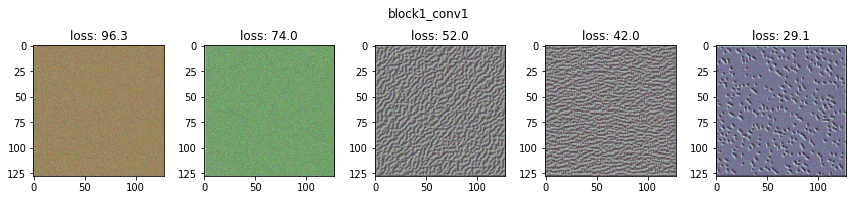

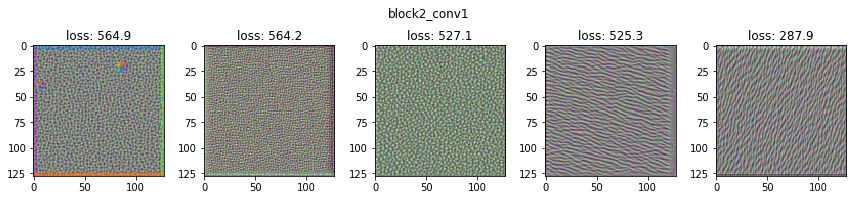

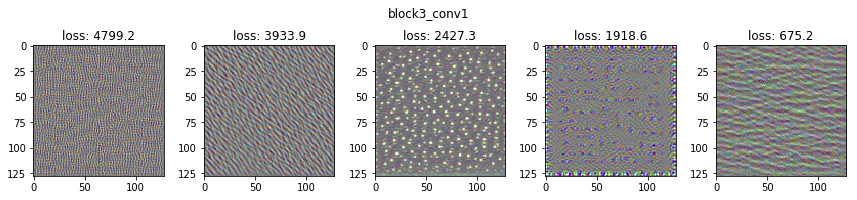

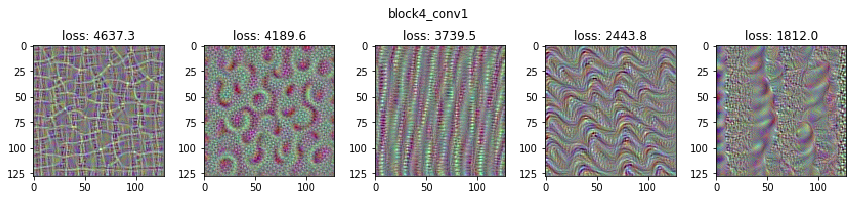

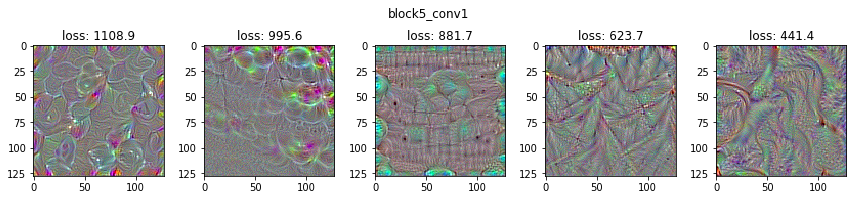

In [86]:
%matplotlib inline

from matplotlib import pyplot as plt

nfilters = 5
layers_all = [('block%d_conv1'%i, layer_dict['block%d_conv1'%i]) for i in range(1,6)]
#layers_all = sorted(layer_dict.items())
for layer_name, layer_output in layers_all:
    kept_filters = image_from_layer(layer_name, layer_output, nfilters, input_img)
    fig, axes = plt.subplots(1, nfilters,figsize=(12, 3))
    for ax, (img, loss_value) in zip(axes.flat, kept_filters):
        ax.imshow(np.array(img))
        ax.set_title("loss: %.1f"%loss_value)
    fig.suptitle(layer_name)
    fig.tight_layout()

## Finding an input that maximizes a specific class
Now for something else --what if you included the fully connected layers at the end of the network, and tried to maximize the activation of a specific output of the network? Would you get an image that looked anything like the class encoded by that output? Let's try it.

In [89]:
# Build the whole VGG network.
# The model loads the pre-trained weights when weights is 'imagenet'
model2 = applications.VGG16(include_top=True, weights='imagenet')
print("Model loaded.")

Model loaded.


In [113]:
# Define new global variables

layer_output2 = model2.output
input_img2 = model2.input
img_width2, img_height2 = 224, 224

In [114]:
# Util function to generate images attached to a specific output

def image_from_index(layer_output, output_index, input_img):
    print('Processing output index %d'%output_index)
    
    # We define new loss here
    loss = K.mean(layer_output[:, output_index])
    # We compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # Normalization trick: we normalize the gradient to avoid too
    # large or to small gradients
    grads = normalize(grads)
    iterate = K.function([input_img], [loss, grads])

    # Step size for gradient ascent
    step = 1.

    # We start from a gray image with some random noise
    # The input format is as follows:
    # (batch, channels, width, height) or (batch, width, height, channels)
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width2, img_height2))
    else:
        input_img_data = np.random.random((1, img_width2, img_height2, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # We run gradient ascent for 20 steps
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data +=  grads_value * step
        #print("Current loss value:", loss_value)
    img = deprocess_image(input_img_data[0])  
    return img

Processing output index 65
Processing output index 66
Processing output index 67
Processing output index 68
Processing output index 69
Processing output index 70


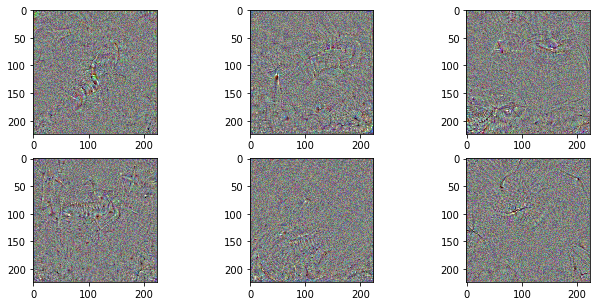

In [134]:
%matplotlib inline

from math import ceil


output_indexs = [65, 66, 67, 68, 69, 70]


ncols = 3
nrows = ceil(len(output_indexs)/ncols)
margin = 1
width = ncols * 3 + (ncols - 1) * margin
height = nrows * 2 + (nrows - 1) * margin

fig, axes = plt.subplots(nrows, ncols, figsize=(width, height))
axes_flat = axes.flat
for output_index, ax in zip(output_indexs, axes_flat):
    img = image_from_index(layer_output2, output_index, input_img2)
    ax.imshow(np.array(img))
    #index_array = np.zeros((1,1000))
    #index_array[0,output_index] = 1
    #label = applications.vgg16.decode_predictions(index_array)[0][0][1]
    #model2.predict(np.array(img))
    #ax.set_title("%s: %.1f"%(label, confidence))
#fig.tight_layout()

In [129]:
width

11

In [130]:
height

7